## Preface



In [22]:
!pip install -r requirements.txt
!pip install eep153_tools

import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
sheet = '1KjQu6ngxR_qxETh9Wx9f9ZmijMVkkevV'

InputFiles = {'Expenditures':(sheet,'Expenditures'),
               'Consumption':(sheet,'Quantities'),
               'HH Characteristics':(sheet,'HH Characteristics'),
               'FCT':(sheet,'FCT')}

quant = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='Quantities')
hh = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='HH Characteristics')
expend = pd.read_excel('Bukidnon 2003.xlsx',sheet_name ='Expenditures')
nut = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='FCT')

In [24]:
r = cfe.result.from_dataset('BUK.ds',engine='netcdf4')

# Energy                            16833.092949
# Protein                             377.781250
# Fiber, total dietary                235.663301
# Folate, DFE                        3269.930070
# Calcium, Ca                       10256.366550
# Carbohydrate, by difference        1179.924242
# Iron, Fe                            127.491987
# Magnesium, Mg                      2703.273237
# Niacin                              119.561407
# Phosphorus, P                      8294.908217
# Potassium, K                      41382.808858
# Riboflavin                            9.158257
# Thiamin                               9.062063
# Vitamin A, RAE                     6074.264277
# Vitamin B-12                         19.619580
# Vitamin B-6                          10.420531
# Vitamin C, total ascorbic acid      569.168124
# Vitamin E (alpha-tocopherol)        121.720862
# Vitamin K (phylloquinone)           706.475816
# Zinc, Zn

# Reference period, market
t,m = 2003, 'Bukidnon'

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(m=m)

p = r.prices.sel(m=m,drop=True)
p = p.to_dataframe('i').squeeze().dropna()
p = p.xs(2003.,level='variable')
p

#lwith this notebook we are looking at min of nutrients per household
#allows getting rid of different units for measuring and think ab ratio instead

i
Bagoong                          0.037190
Banana                           0.021401
Beef                             0.135031
Carrots                          0.027822
Chicken                          0.097764
Coffee                           0.732034
Cooking oil                      0.038578
Eggs                             0.092641
Food made from flour             0.016472
Fresh fish                       0.046502
Mangoes                          0.045497
Milk                             0.277523
Milo                             0.217887
Mongo and other products         0.038700
Onions                           0.043971
Peanut                           0.170558
Pork                             0.102934
Potato                           0.028599
Processed meat like longanisa    0.144143
Rice                             0.021202
Salt                             0.015549
Sardines                         0.078127
Sea weed                         0.035359
Soybean and other products      

## Nutritional requirements



Individuals have nutritional requirements established by nutrition
scientists.  Here are some standards established by the Indian
National Institute of Nutrition:



### Nutritional Needs of individuals



#### Recommended Daily Allowances: India



| Sex-Age|Calories|Protein|Fat|Calcium|Iron|Betacarotene|Thiamine|Riboflavin|Niacin|Ascorbic Acid|
|---|---|---|---|---|---|---|---|---|---|---|
| C 0-0.5||||500|||.2|.3||25|
| C 0.5-1|||19|500|5|2800|.3|.4||25|
| C 1-3|1060|16.7|27|600|9|3200|.5|.6|8|40|
| C 4-6|1350|20.1|25|600|13|3200|.7|.8|11|40|
| C 7-9|1690|29.5|30|600|16|4800|.8|1.|13|40|
| B 10-12|2190|39.9|35|800|21|4800|1.1|1.3|15|40|
| G 10-12|2010|40.4|35|800|27|4800|1.|1.2|13|40|
| B 13-15|2750|54.3|45|800|32|4800|1.4|1.6|16|40|
| G 13-15|2330|51.9|40|800|27|4800|1.2|1.4|14|40|
| B 16-17|3020|61.5|50|800|28|4800|1.5|1.8|17|40|
| G 16-17|2440|55.5|35|800|26|4800|1.|1.2|14|40|
| M|2730|60|30|600|17|4800|1.4|1.4|18|40|
| W|2230|55|25|1200|21|4800|1.1|1.3|14|40|



### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in the ICRISAT villages, the number of
different kinds of people can be computed by averaging over households:



In [25]:
# In first round, averaged over households and villages

zbar = r.z.sel(t=r.firstround,drop=True).mean(['j','m'])[:-1].squeeze() # Leave out log HSize

zbar = zbar.to_dataframe().squeeze()
zbar

k
Males 0-1         0.094406
Males 1-5         0.276224
Males 5-10        0.255245
Males 10-15       0.323427
Males 15-20       0.363636
Males 20-30       0.973776
Males 30-50       0.858392
Males 50-60       0.208042
Males 60-100      0.162587
Females 0-1       0.073427
Females 1-5       0.232517
Females 5-10      0.284965
Females 10-15     0.305944
Females 15-20     0.368881
Females 20-30     0.809441
Females 30-50     0.802448
Females 50-60     0.222028
Females 60-100    0.134615
Name: z, dtype: float64

Now, the inner/dot/matrix product between `zbar` and the `rda`
DataFrame of requirements will give us minimum requirements for the
average household:



In [26]:
rda = pd.read_csv('diet_minimums.csv').set_index('Nutrition').iloc[:,2:]

zbar['Boys'] = zbar['Males 5-10']*5/15 + zbar['Males 10-15']*5/15 + zbar['Males 15-20'] * 5/15
zbar['Girls'] = zbar['Females 5-10']*5/15 + zbar['Females 10-15']*5/15 + zbar ['Females 15-20'] * 5/15
zbar['Mothers'] = zbar['Females 15-20']*5/15 + zbar['Females 20-30']*10/15

rda['Boys'] = rda['M 4-8']*4/16 + rda['M 9-13']*5/16 + rda['M 14-18']*5/16 + rda['M 19-30']*2/16
rda['Girls'] = rda['F 4-8']*4/16 + rda['F 9-13']*5/16 + rda['F 14-18']*5/16 + rda['F 19-30']*2/16
rda['Mothers'] = rda['F 14-18']*4/16 + rda['F 19-30']*12/16

zbar = zbar[['Boys', 'Girls', 'Mothers']]
rda = rda[['Boys', 'Girls', 'Mothers']]
# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda.align(zbar,axis=1)
# This matrix product gives minimum nutrient requirements for average
# household in 1975
hh_rda = rda0.replace('',0)@zbar0
# RDA is /daily/, but  demands in BUK data are /weekly/:
hh_rda = hh_rda*7
hh_rda

Nutrition
Energy                            16833.092949
Protein                             377.781250
Fiber, total dietary                235.663301
Folate, DFE                        3269.930070
Calcium, Ca                       10256.366550
Carbohydrate, by difference        1179.924242
Iron, Fe                            127.491987
Magnesium, Mg                      2703.273237
Niacin                              119.561407
Phosphorus, P                      8294.908217
Potassium, K                      41382.808858
Riboflavin                            9.158257
Thiamin                               9.062063
Vitamin A, RAE                     6074.264277
Vitamin B-12                         19.619580
Vitamin B-6                          10.420531
Vitamin C, total ascorbic acid      569.168124
Vitamin E (alpha-tocopherol)        121.720862
Vitamin K (phylloquinone)           706.475816
Zinc, Zn                             74.027244
dtype: float64

## Nutritional Adequacy of Food Demands



### Food Conversion Table



As usual, we need data to convert foods to nutrients:



In [27]:
UseNutrients=['calorie','protein','calcium','carbo','iron']

In [28]:
from eep153_tools.sheets import read_sheets

# DataURL = 'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'
# key = DataURL.split('/')[-1]

# fct = read_sheets(key,sheet='FCT').set_index('i')

fct = nut.iloc[:,3:]
fct['i'] = fct['name']
fct = fct.set_index('i').iloc[:,1:]

# Select only desired nutrients from the fct table
fct = fct[UseNutrients]

# Rename and select desired nutrients from the hh_rda series
hh_rda = hh_rda[['Energy','Protein','Calcium, Ca','Carbohydrate, by difference','Iron, Fe']]
hh_rda = hh_rda.rename({'Energy':'calorie','Protein':'protein','Calcium, Ca':'calcium',
                        'Carbohydrate, by difference':'carbo','Iron, Fe':'iron'})

In [29]:
hh_rda

Nutrition
calorie    16833.092949
protein      377.781250
calcium    10256.366550
carbo       1179.924242
iron         127.491987
dtype: float64

In [52]:
# fct['calcium'].sort_values(ascending=False)

In [53]:
# fct['iron'].sort_values(ascending=False)

In [54]:
# fct['protein'].sort_values(ascending=False)

In [55]:
# fct['carbo'].sort_values(ascending=False)

In [56]:
# fct['calorie'].sort_values(ascending=False)

### Prices



In [35]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

In [36]:
# myp = p.xs(2003.,level='variable')
# myp

### Nutrient Demand



We can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [44]:
import warnings 

def nutrient_demand(x,p):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    c = r.demands(x,p)    
    
#     print(c.index.intersection(fct.index))

    fct0,c0 = fct.align(c,axis=0,join='inner')
    
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



In [61]:
# my_prices(3,p,i='Rice')

In [72]:
# #just checking things
# np.log(nutrient_demand(X[0],my_prices(3,p,i='Potato')))[UseNutrients]
#pd.concat([np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X],axis=1)

In [40]:
# %debug

Text(0, 0.5, 'log nutrient')

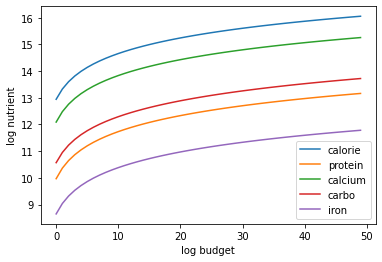

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)

# UseNutrients=['Energy','Protein','Carbohydrate, by difference','Iron, Fe','Vitamin A, RAE','Vitamin B-12']
# calorie	protein	fat	carbo	fiber	ash	calcium	phos	iron
# UseNutrients=['calorie','protein','carbo','calcium','iron']

# wanted Vitamin A/B-12 and carbs but not there

# df = pd.concat({myx:np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X},axis=1).T
df = pd.concat([np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X],axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



Text(0.5, 1.0, 'Sardines')

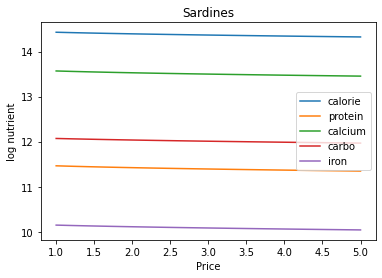

In [88]:
USE_GOOD = 'Sardines' # Also try Rice and Potato

# ref_price = r.prices.sel(i=USE_GOOD,m=m,drop=True)

P = np.linspace(1,5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T
# rice = pd.DataFrame({p0:np.log(r.demands(reference_x,my_prices(p0,p=myp,i=USE_GOOD)))['Rice'] for p0 in P}).T
ax = ndf.plot()

ax.set_xlabel('Price')
ax.set_ylabel('log nutrient')
ax.set_title(USE_GOOD)

In [ ]:
# np.log(r.demands(reference_x,my_prices(34,p=myp,i=USE_GOOD)))['Rice']

### Nutritional Adequacy



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet.



In [76]:
def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



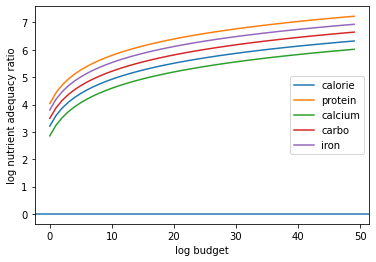

In [77]:
X = np.linspace(reference_x/5,reference_x*5,50)

# ndf = pd.concat({x:np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X},axis=1).T
ndf = pd.concat([np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X],axis=1).T

ax = ndf.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



Text(0.5, 1.0, 'Sardines')

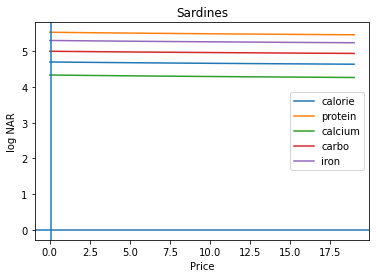

In [90]:
USE_GOOD = 'Sardines'

poorer_x = reference_x/2

Pscale = np.linspace(1,3,20).tolist()

# log_nar = {s0:np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] for s0 in Pscale}
log_nar = [np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] 
           for s0 in Pscale]

log_nar = pd.DataFrame(log_nar) 

ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


ax.axhline(0)
ax.axvline(p[USE_GOOD])
ax.set_title(USE_GOOD)